## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy, read_each_loader, convert_sample_2_df

from models.policy_model import RobotPolicy

In [2]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory)

Evaluating Device:  cpu
Current Time:  Jan_30_2024-18_35_38


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load demonstrations dataset
evaluation_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  20
Full Demo Dataset Size:  922


# Functions

In [6]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"MAE = {mae:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend()
    
    plt.show()

# Test

In [7]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Jan_29_2024-18_35_10"

In [8]:
params_name = "policy_network_epoch_100_loss_3_19916.pt"

In [9]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [10]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [11]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [12]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

In [13]:
sample_index = 25

In [14]:
evaluation_sample = evaluation_data[sample_index]

In [15]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [16]:
# forward pass to get mean of Gaussian distribution
# add a batch dimension by unsqueezing
action_pred, action_std = policy_network.forward(x=input_state.unsqueeze(0))
action_log_prob, action_dist = policy_network.calculate_distribution(action_mu=action_pred,
                                                                     action_std=action_std)

In [17]:
action_mu_and_std = torch.cat((action_pred, action_std),
                              dim=-1)

In [18]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [19]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=evaluation_data.state_norms)

In [20]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=evaluation_data.action_norms)[0]

In [21]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=evaluation_data.action_norms)[0]

# Run Through All Samples in a Trajectory for Every Trajectory

In [22]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [23]:
for idx, sample_data in enumerate(evaluation_data):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=sample_data)
    
    # forward pass to get mean of Gaussian distribution
    # add a batch dimension by unsqueezing
    action_pred, action_std = policy_network.forward(x=input_state.unsqueeze(0))
    action_log_prob, action_dist = policy_network.calculate_distribution(action_mu=action_pred,
                                                                         action_std=action_std)
    
    action_mu_and_std = torch.cat((action_pred, action_std),
                                  dim=-1)
    
    # multivariate Gaussian negative log-likelihood loss function
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=evaluation_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                                   norm_range_list=evaluation_data.action_norms)[0]
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=evaluation_data.action_norms)[0]
    
    # store every important detail in the dataframe
    sample_df = convert_sample_2_df(input_state=input_state,
                                    real_state_input=real_state_input,
                                    output_action=output_action,
                                    real_action_output=real_action_output,
                                    action_log_prob=action_log_prob,
                                    action_pred=action_pred,
                                    action_std=action_std,
                                    real_action_pred=real_action_pred,
                                    trajectory_index=int(trajectory_index),
                                    state_number=int(state_number),
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        df = pd.concat([df, sample_df],
                       ignore_index=True)
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

In [24]:
trajectory_dataframes[-1]

,state_norm_1,state_norm_2,state_norm_3,state_norm_4,state_denorm_1,state_denorm_2,state_denorm_3,state_denorm_4,action_label_norm_1,action_label_norm_2,...,action_pred_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss
0,0.743231832981,1.126864194870,0.203032135963,0.548825860023,1.114847749472,1.690296292305,0.304548203945,0.823238790035,-0.182325437665,-0.437485992908,...,0.467582225800,0.147250264883,0.147255048156,0.147250279784,-0.311127662659,-0.610331535339,0.701373338699,41,0,3.199161291122
1,0.734964132309,1.123658061028,0.200832962990,0.522036135197,1.102446198463,1.685487091541,0.301249444485,0.783054202795,-0.207049548626,-0.430095970631,...,0.446235120296,0.147250264883,0.147255048156,0.147250279784,-0.345409989357,-0.624297261238,0.669352769852,41,1,3.198884963989
2,0.622784197330,1.043167710304,0.141411662102,0.476814597845,0.934176295996,1.564751565456,0.212117493153,0.715221896768,-0.275715947151,-0.351942837238,...,0.394857198000,0.147250264883,0.147255048156,0.147250279784,-0.482713818550,-0.540911078453,0.592285633087,41,2,3.200126171112
3,0.503993630409,0.955137312412,0.158967658877,0.476754903793,0.755990445614,1.432705968618,0.238451488316,0.715132355690,-0.344615906477,-0.257385015488,...,0.391066879034,0.147250264883,0.147255048156,0.147250279784,-0.589200139046,-0.401229381561,0.586600303650,41,3,3.200271129608
4,0.386585384607,0.855347812176,0.236910030246,0.462549000978,0.579878076911,1.283021718264,0.355365045369,0.693823501468,-0.366099864244,-0.156318739057,...,0.386829346418,0.147250264883,0.147255048156,0.147250279784,-0.627163231373,-0.242725491524,0.580244064331,41,4,3.201057910919
5,0.304150432348,0.770659625530,0.334505170584,0.458755642176,0.456225648522,1.155989438295,0.501757755876,0.688133463264,-0.383321017027,-0.042653478682,...,0.398905277252,0.147250264883,0.147255048156,0.147250279784,-0.635694742203,-0.075208544731,0.598357915878,41,5,3.200574874878
6,0.252165108919,0.685313224792,0.423649936914,0.431872844696,0.378247663379,1.027969837189,0.635474905372,0.647809267044,-0.374663978815,0.061579231173,...,0.393032371998,0.147250264883,0.147255048156,0.147250279784,-0.613941013813,0.078500270844,0.589548587799,41,6,3.200174093246
7,0.256842046976,0.608801603317,0.500670611858,0.440847486258,0.385263070464,0.913202404976,0.751005917788,0.661271229386,-0.352480232716,0.145986273885,...,0.404117673635,0.147250264883,0.147255048156,0.147250279784,-0.533455967903,0.234215497971,0.606176614761,41,7,3.199025869370
8,0.270761340857,0.560170054436,0.586265504360,0.380165457726,0.406142011285,0.840255081654,0.879398256540,0.570248186588,-0.344531118870,0.242989718914,...,0.385601580143,0.147250264883,0.147255048156,0.147250279784,-0.557019352913,0.338973522186,0.578402280807,41,8,3.199307441711
9,0.306861370802,0.464549452066,0.679891407490,0.314392656088,0.460292056203,0.696824178100,1.019837111235,0.471588984132,-0.317130267620,0.342481851578,...,0.342040657997,0.147250264883,0.147255048156,0.147250279784,-0.506637275219,0.500701189041,0.513061046600,41,9,3.198900461197


In [25]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

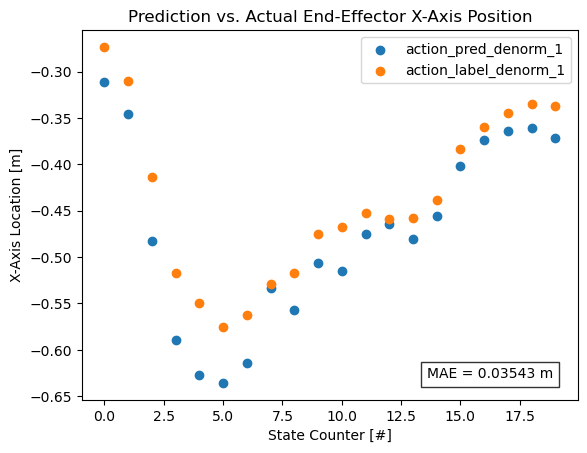

In [27]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)